# Multimodal Network

Create GNN for each of the dimensions and later combine them into a single network.

1. Each dimension is a separate graph and gets its own GNN.
2. Dimensions are connected in a MLP layer.

#### Import Libraries

In [2]:
print("hello world")

hello world


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import country_converter as coco
import functools
import os
from torchmetrics.regression import MeanAbsolutePercentageError


# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.chdir('/home/jovyan/dlss-project')
print("Current working directory:", os.getcwd())

cuda
Current working directory: /home/jovyan/dlss-project


## Data

In [4]:
path_geo_edges = "data_collection/geography/edges_yearly_dist_enc.parquet"
path_geo_nodes = "data_collection/geography/nodes_enc.parquet"
df_geo_edges = pd.read_parquet(path_geo_edges)
df_geo_nodes = pd.read_parquet(path_geo_nodes)

path_pol_edges = "data_collection/political/data/edge_features.parquet"
path_pol_nodes = "data_collection/political/data/node_features.parquet"
df_pol_edges = pd.read_parquet(path_pol_edges)
df_pol_nodes = pd.read_parquet(path_pol_nodes)

path_cult_edges = "data_collection/culture/culture_edges.parquet"
path_cult_nodes = "data_collection/culture/culture_nodes.parquet"
df_cult_edges = pd.read_parquet(path_cult_edges)
df_cult_nodes = pd.read_parquet(path_cult_nodes)

path_lang_edges = "data_collection/culture/language_religion_edges.parquet"
path_lang_nodes = "data_collection/culture/language_religion_nodes.parquet"
df_lang_edges = pd.read_parquet(path_lang_edges)
df_lang_nodes = pd.read_parquet(path_lang_nodes)

path_eco_edges = "data_collection/economics/edges_economics.parquet"
path_eco_nodes = "data_collection/economics/nodes_economics.parquet"
df_eco_edges = pd.read_parquet(path_eco_edges)
df_eco_nodes = pd.read_parquet(path_eco_nodes)

path_gini = "data_collection/gini.parquet"
df_gini = pd.read_parquet(path_gini)
df_gini = df_gini[df_gini['year'].between(2000, 2022)].reset_index(drop=True)

In [ ]:
# Pre-compute UN member countries once
@functools.lru_cache(maxsize=1)
def get_un_countries():
    """Cache UN member countries to avoid repeated lookups"""
    iso3 = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['ISO3'].dropna().tolist()
    unnumeric = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['UNcode'].dropna().tolist()
    return iso3, unnumeric


@functools.lru_cache(maxsize=1000)
def convert_country_code(country, target_format='UNnumeric'):
    """Cache country code conversions"""
    return coco.convert(names=country, to=target_format, not_found=None)


def prepare_frames(edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col="year"):
    """
    Filter to UN members, map country ids, coerce dtypes, but DO NOT scale yet.
    Returns:
      edge_df, node_df, edge_feature_cols, node_feature_cols, usable_years
    """
    uno_iso3_codes, _ = get_un_countries()

    # Filter to UN members (both ends for edges; country for nodes)
    edge_mask = edge_df[edge_country_a_col].isin(uno_iso3_codes) & edge_df[edge_country_b_col].isin(uno_iso3_codes)
    node_mask = node_df[node_country_col].isin(uno_iso3_codes)
    edge_df = edge_df[edge_mask].copy()
    node_df = node_df[node_mask].copy()

    # Ensure year int
    edge_df[year_col] = edge_df[year_col].astype(int)
    node_df[year_col] = node_df[year_col].astype(int)

    # Vectorized country code conversion
    unique_countries_edges = pd.concat([edge_df[edge_country_a_col], edge_df[edge_country_b_col]]).unique()
    unique_countries_nodes = node_df[node_country_col].unique()
    all_unique_countries = np.unique(np.concatenate([unique_countries_edges, unique_countries_nodes]))

    country_to_id_map = dict(zip(
        all_unique_countries,
        coco.convert(all_unique_countries.tolist(), to='UNnumeric', not_found=None)
    ))

    # Apply mapping
    edge_df['country_id_a'] = edge_df[edge_country_a_col].map(country_to_id_map)
    edge_df['country_id_b'] = edge_df[edge_country_b_col].map(country_to_id_map)
    node_df['country_id'] = node_df[node_country_col].map(country_to_id_map)

    # Drop unmapped
    edge_df = edge_df.dropna(subset=['country_id_a', 'country_id_b'])
    node_df = node_df.dropna(subset=['country_id'])

    # Cast ids
    edge_df['country_id_a'] = edge_df['country_id_a'].astype(int)
    edge_df['country_id_b'] = edge_df['country_id_b'].astype(int)
    node_df['country_id'] = node_df['country_id'].astype(int)

    # Feature columns (exclude ids & year; keep original code cols for edges out)
    edge_feature_cols = [
        c for c in edge_df.columns
        if c not in [edge_country_a_col, edge_country_b_col, year_col, 'country_id_a', 'country_id_b']
    ]
    node_feature_cols = [
        c for c in node_df.columns
        if c not in [node_country_col, year_col, 'country_id']
    ]

    # Convert bools once (faster than per-year)
    bool_cols_edges = edge_df[edge_feature_cols].select_dtypes(include='bool').columns
    if len(bool_cols_edges):
        edge_df[bool_cols_edges] = edge_df[bool_cols_edges].astype(int)
    bool_cols_nodes = node_df[node_feature_cols].select_dtypes(include='bool').columns
    if len(bool_cols_nodes):
        node_df[bool_cols_nodes] = node_df[bool_cols_nodes].astype(int)

    # Years we’ll build graphs for (restricted to 2000–2022)
    years = sorted(set(edge_df[year_col]).intersection(set(range(2000, 2023))))

    return edge_df, node_df, edge_feature_cols, node_feature_cols, years

def fit_apply_scalers(node_df, edge_df, node_feature_cols, edge_feature_cols, train_years, year_col='year'):
    """
    Fit StandardScaler on TRAIN YEARS ONLY; transform all years (prevents leakage).
    """
    # Fit on train years only
    node_train = node_df[node_df[year_col].isin(train_years)]
    edge_train = edge_df[edge_df[year_col].isin(train_years)]

    node_scaler = StandardScaler().fit(node_train[node_feature_cols]) if node_feature_cols else None
    edge_scaler = StandardScaler().fit(edge_train[edge_feature_cols]) if edge_feature_cols else None

    # Transform full data
    if node_feature_cols:
        node_df.loc[:, node_feature_cols] = node_scaler.transform(node_df[node_feature_cols])
    if edge_feature_cols:
        edge_df.loc[:, edge_feature_cols] = edge_scaler.transform(edge_df[edge_feature_cols])

    return node_df, edge_df

def build_year_graphs(edge_df, node_df, years, edge_feature_cols, node_feature_cols, uno_unnumeric_codes, year_col='year'):
    """
    Build one PyG Data per year (same as your original create_data's per-year section),
    but assumes scaling already applied.
    """
    data_dict = {}
    for year in years:
        edge_df_year = edge_df[edge_df[year_col] == year]
        node_df_year = node_df[node_df[year_col] == year].copy()

        # Drop duplicate nodes per (country_id, year)
        node_df_year = node_df_year.drop_duplicates(subset=['country_id', year_col], keep='first')

        # Ensure exists flag & fill missing countries for the year
        node_df_year['exists'] = 1
        existing = set(node_df_year['country_id'])
        missing = set(uno_unnumeric_codes) - existing
        if missing:
            missing_rows = pd.DataFrame({
                'country_id': list(missing),
                year_col: year,
                **{c: 0 for c in node_feature_cols},
                'exists': 0
            })
            node_df_year = pd.concat([node_df_year, missing_rows], ignore_index=True)

        # Sort by country_id
        node_df_year_sorted = node_df_year.sort_values(by='country_id').reset_index(drop=True)

        # Build tensors
        node_features = torch.tensor(
            node_df_year_sorted[node_feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0).values,
            dtype=torch.float32
        )
        country_id_tensor = torch.tensor(node_df_year_sorted['country_id'].values, dtype=torch.long)

        edge_features_df = edge_df_year[edge_feature_cols].copy()
        edge_features_df = edge_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        edge_attr = torch.from_numpy(edge_features_df.values.astype(np.float32))

        # Map edge indices to node positions
        pos_map = {cid: i for i, cid in enumerate(node_df_year_sorted['country_id'].values)}
        edge_index = torch.tensor(
            [
                edge_df_year['country_id_a'].map(pos_map).values,
                edge_df_year['country_id_b'].map(pos_map).values
            ],
            dtype=torch.long
        )

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, country_id=country_id_tensor)
        data_dict[year] = data

    return data_dict

# ----------------- Gini handling (unchanged from your Prep 2) -----------------
def create_gini_data(df_gini, year_col='year', country_col='country', gini_col='gini'):
    uno_iso3_codes, _ = get_un_countries()
    df_gini = df_gini[df_gini[country_col].isin(uno_iso3_codes)].copy()
    df_gini['country_id'] = df_gini[country_col].map(lambda x: convert_country_code(x, 'UNnumeric'))
    df_gini = df_gini.sort_values(by=['country_id']).reset_index(drop=True)
    df_gini = df_gini.dropna(subset=['country_id'])
    df_gini[gini_col] = df_gini[gini_col] / 100
    df_gini['exists'] = 1
    df_gini.loc[df_gini[gini_col].isna(), 'exists'] = 0
    df_gini.loc[df_gini[gini_col].isna(), gini_col] = 0

    gini_data_dict = {}
    years = df_gini[year_col].unique()
    for year in years:
        df_year = df_gini[df_gini[year_col] == year].copy()
        df_year['country_id'] = df_year['country_id'].astype(int)
        gini_tensor = torch.tensor(df_year[gini_col].values, dtype=torch.float32)
        country_id_tensor = torch.tensor(df_year['country_id'].values, dtype=torch.long)
        data = Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, exists=df_year['exists'].values)
        gini_data_dict[year] = data
    return gini_data_dict

# ----------------- Orchestration per modality with proper scaling -----------------

from sklearn.model_selection import train_test_split

def build_modality(edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col="year"):
    """
    Full pipeline for a modality:
      1) prepare frames (no scaling)
      2) split years
      3) fit scalers on TRAIN years only
      4) build per-year graphs from scaled frames
    Returns: (data_by_year, train_years, val_years, test_years)
    """
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # 1) prepare
    edge_df, node_df, edge_feature_cols, node_feature_cols, years = prepare_frames(
        edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col=year_col
    )

    # 2) year split (80/20 then 60/20/20 like your original)
    all_years = sorted(years)
    train_years, test_years = train_test_split(all_years, test_size=0.2, random_state=42)
    train_years, val_years = train_test_split(train_years, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

    # 3) fit scaling on TRAIN years only; apply to all
    node_df, edge_df = fit_apply_scalers(
        node_df, edge_df, node_feature_cols, edge_feature_cols, train_years, year_col=year_col
    )

    # 4) build per-year graphs
    data_by_year = build_year_graphs(
        edge_df, node_df, years, edge_feature_cols, node_feature_cols, uno_unnumeric_codes, year_col=year_col
    )

    return data_by_year, train_years, val_years, test_years


In [6]:
# ----------------- Build all modalities -----------------

geo_data, geo_train_years, geo_val_years, geo_test_years = build_modality(
    df_geo_edges, df_geo_nodes, 'iso_o', 'iso_d', 'code_3', year_col='year'
)
pol_data, pol_train_years, pol_val_years, pol_test_years = build_modality(
    df_pol_edges, df_pol_nodes, 'state1', 'state2', 'country', year_col='year'
)
cul_data, cul_train_years, cul_val_years, cul_test_years = build_modality(
    df_cult_edges, df_cult_nodes, 'ISO3_a', 'ISO3_b', 'ISO3', year_col='year'
)
lang_data, lang_train_years, lang_val_years, lang_test_years = build_modality(
    df_lang_edges, df_lang_nodes, 'country_a', 'country_b', 'ISO3', year_col='year'
)
eco_data, eco_train_years, eco_val_years, eco_test_years = build_modality(
    df_eco_edges, df_eco_nodes, 'src_ISO3', 'tgt_ISO3', 'ISO3', year_col='year'
)

# Compose year -> modality dict (same shape as before)
gini_data = create_gini_data(df_gini, year_col='year', country_col='country', gini_col='gini')

data_years = {}
# Use intersection of available years across modalities (or choose a reference, e.g., geo_data.keys())
common_years = sorted(set(geo_data.keys()) & set(pol_data.keys()) & set(cul_data.keys()) & set(lang_data.keys()) & set(eco_data.keys()))
for year in common_years:
    data_years[year] = {
        'geography': geo_data[year],
        'political': pol_data[year],
        'culture': cul_data[year],
        'language': lang_data[year],
        'economy': eco_data[year],
        'GINI': gini_data.get(year)  # may be missing for some years; handle with .get
    }

# Keep your dimension helper (example for 2000 if present)
network_dimesions = {
    'geography': {
        'node_features': data_years[2000]['geography'].x.shape[1],
        'edge_features': data_years[2000]['geography'].edge_attr.shape[1]
    },
    'political': {
        'node_features': data_years[2000]['political'].x.shape[1],
        'edge_features': data_years[2000]['political'].edge_attr.shape[1]
    },
    'culture': {
        'node_features': data_years[2000]['culture'].x.shape[1],
        'edge_features': data_years[2000]['culture'].edge_attr.shape[1]
    },
    'language': {
        'node_features': data_years[2000]['language'].x.shape[1],
        'edge_features': data_years[2000]['language'].edge_attr.shape[1]
    },
    'economy': {
        'node_features': data_years[2000]['economy'].x.shape[1],
        'edge_features': data_years[2000]['economy'].edge_attr.shape[1]
    },
}

# If you still want train/val/test as lists of years (like your original):
all_years = sorted(data_years.keys())
train_years, test_years = train_test_split(all_years, test_size=0.2, random_state=42)
train_years, val_years = train_test_split(train_years, test_size=0.25, random_state=42)

train_set = [data_years[y] for y in train_years]
val_set   = [data_years[y] for y in val_years]
test_set  = [data_years[y] for y in test_years]

/tmp/ipykernel_566/2010071284.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.61969166 -0.61969166 -0.61969166 ...  1.61370575  1.61370575
  1.61370575]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  node_df.loc[:, node_feature_cols] = node_scaler.transform(node_df[node_feature_cols])
/tmp/ipykernel_566/2010071284.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.47238607 -0.47238607 -0.47238607 ... -0.47238607 -0.47238607
 -0.47238607]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  node_df.loc[:, node_feature_cols] = node_scaler.transform(node_df[node_feature_cols])
/tmp/ipykernel_566/2010071284.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.75741987  1.75741987 

In [7]:
print("Train years:", len(train_set))
print("Validation years:", len(val_set))
print("Test years:", len(test_set))

Train years: 13
Validation years: 5
Test years: 5


In [8]:
network_dimesions

{'geography': {'node_features': 28, 'edge_features': 16},
 'political': {'node_features': 7, 'edge_features': 5},
 'culture': {'node_features': 6, 'edge_features': 11},
 'language': {'node_features': 7, 'edge_features': 2},
 'economy': {'node_features': 3, 'edge_features': 1}}

## Model Setup

In [ ]:
# GNN model for each of the different networks
class DimensionModel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_size=64, target_size=1, n_gat_layers=2, n_mlp_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_node_features = num_node_features
        self.num_edge_features = num_edge_features
        self.target_size = target_size
        # Dynamically create GAT layers
        self.convs = nn.ModuleList()
        self.convs.append(GATv2Conv(self.num_node_features, self.hidden_size, edge_dim=num_edge_features))
        for _ in range(n_gat_layers - 1):
            self.convs.append(GATv2Conv(self.hidden_size, self.hidden_size, edge_dim=num_edge_features))

        # Dynamically create MLP layers
        self.n_mlp_layers = n_mlp_layers
        mlp_layers = []
        for _ in range(n_mlp_layers):
            mlp_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(0.2))
        self.mlp = nn.Sequential(*mlp_layers)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)
        if self.n_mlp_layers > 0:
            x = self.mlp(x)  # Apply the fully connected layer
        return x
    
class MultiModalGNNModel(nn.Module):
    def __init__(self, 
                 input_dims,
                 hidden_size=64,
                 final_output_size=1, 
                 n_gat_layers=2,
                 n_dim_mlp_layers=2,
                 combination_method='concat',
                 mlp_variant='default'):
        super().__init__()
        self.combination_method = combination_method

        self.geo_model = DimensionModel(input_dims['geography']['node_features'], input_dims['geography']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.pol_model = DimensionModel(input_dims['political']['node_features'], input_dims['political']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.cult_model = DimensionModel(input_dims['culture']['node_features'], input_dims['culture']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.lang_model = DimensionModel(input_dims['language']['node_features'], input_dims['language']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.eco_model = DimensionModel(input_dims['economy']['node_features'], input_dims['economy']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)

        self.num_modalities = 5
        self.hidden_size = hidden_size

        if self.combination_method == 'attention':
            # Learnable attention weights for each modality
            self.attn_weights = nn.Parameter(torch.ones(self.num_modalities))

        self.fusion_input_size = hidden_size * self.num_modalities if combination_method == 'concat' else hidden_size
        if mlp_variant == 'default':
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, final_output_size)
            )
        elif mlp_variant == 'deep':
            # Deeper MLP variant
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, final_output_size)
            )
        elif mlp_variant == 'shallow':
            # Shallow MLP variant
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, final_output_size)
            )        
    

    def forward(self, data_dict):
        geo_emb = self.geo_model(data_dict['geography'])
        pol_emb = self.pol_model(data_dict['political'])
        cult_emb = self.cult_model(data_dict['culture'])
        lang_emb = self.lang_model(data_dict['language'])
        eco_emb = self.eco_model(data_dict['economy'])

        embeddings = [geo_emb, pol_emb, cult_emb, lang_emb, eco_emb]

        if self.combination_method == 'concat':
            # Concatenate embeddings along the last dimension
            fused = torch.cat(embeddings, dim=-1)
        elif self.combination_method == 'attention':
            # Stack embeddings: shape [num_nodes, num_modalities, hidden_size]
            stacked = torch.stack(embeddings, dim=1)  # [num_nodes, num_modalities, hidden_size]
            attn = torch.softmax(self.attn_weights, dim=0)  # [num_modalities]
            attn = attn.view(1, self.num_modalities, 1)     # [1, num_modalities, 1] for broadcasting
            fused = (stacked * attn).sum(dim=1)             # [num_nodes, hidden_size]
        output = self.mlp(fused)
        return output

## Training Setup

In [10]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt', printing=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model
        self.printing = printing
        
        # remove model if path already exists
        if os.path.exists(path):
          os.remove(path)
          if self.printing:
            print(f"Removing existing model at: {path}")

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        if self.printing:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        
def train_gnn(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, printing=True):    
    # Make sure device is defined
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the data and model to the device
    # data_dict = move_data_to_device(data_dict, device)

    # model = model.to(device)

    train_losses = []
    val_losses = []
    
    if printing:
        print("Starting training...")

    for epoch in range(epochs):
        model.train()
        train_loss_temp = 0
        for data_dict in train_loader:
            # Training

            optimizer.zero_grad()

            # Forward pass on the entire graph
            output = model(data_dict)
            mask = torch.tensor(data_dict['GINI'].exists, dtype=torch.bool, device=output.device).flatten()
            target = data_dict['GINI'].y

            # Calculate loss using only valid entries
            train_loss = criterion(output[mask], target[mask])

            # Backward pass
            train_loss.backward()
            optimizer.step()
            train_loss_temp += train_loss.item()

        train_losses.append(train_loss_temp / len(train_loader))

        # Validation
        model.eval()
        val_loss_temp = 0
        with torch.no_grad():
            for data_dict in val_loader:
                output = model(data_dict)
                mask = torch.tensor(data_dict['GINI'].exists, dtype=torch.bool, device=output.device).flatten()
                target = data_dict['GINI'].y
                val_loss = criterion(output[mask], target[mask])
                val_loss_temp += val_loss.item()
        val_losses.append(val_loss_temp / len(val_loader))
        if printing:
            print(f'Epoch: {epoch+1}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            if printing:
                print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses

## Training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def move_data_dict_to_device(data_dict, device):
    moved = {}
    for k, v in data_dict.items():
        if hasattr(v, 'to'):
            moved[k] = v.to(device)
        else:
            moved[k] = v
    return moved

train_set = [move_data_dict_to_device(d, device) for d in train_set]
val_set = [move_data_dict_to_device(d, device) for d in val_set]
test_set = [move_data_dict_to_device(d, device) for d in test_set]

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

Removing existing model at: model_checkpoints/gan_checkpoint.pt
Starting training...
Epoch: 1, Training Loss: 0.3182, Validation Loss: 0.1118
Validation loss decreased (0.111820 --> 0.111820).  Saving model ...
Epoch: 2, Training Loss: 0.2525, Validation Loss: 0.1134
Epoch: 3, Training Loss: 0.1901, Validation Loss: 0.0710
Validation loss decreased (0.111820 --> 0.070996).  Saving model ...
Epoch: 4, Training Loss: 0.2175, Validation Loss: 0.0579
Validation loss decreased (0.070996 --> 0.057895).  Saving model ...
Epoch: 5, Training Loss: 0.1566, Validation Loss: 0.0821
Epoch: 6, Training Loss: 0.1591, Validation Loss: 0.0554
Validation loss decreased (0.057895 --> 0.055440).  Saving model ...
Epoch: 7, Training Loss: 0.1336, Validation Loss: 0.0794
Epoch: 8, Training Loss: 0.1040, Validation Loss: 0.0571
Epoch: 9, Training Loss: 0.0941, Validation Loss: 0.0763
Epoch: 10, Training Loss: 0.0878, Validation Loss: 0.0571
Epoch: 11, Training Loss: 0.0659, Validation Loss: 0.0500
Validation

Text(0.5, 1.0, 'Training Progress')

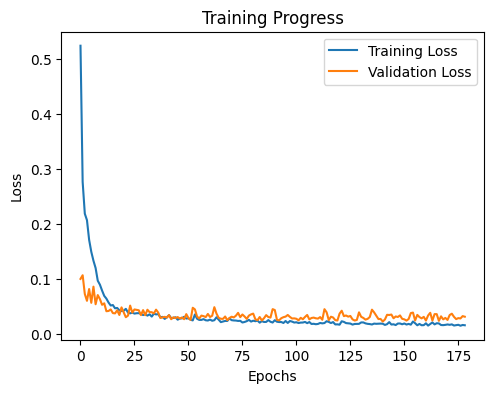

In [12]:
gan_model = MultiModalGNNModel(
    input_dims=network_dimesions, hidden_size=148, n_dim_mlp_layers=0, combination_method="attention", mlp_variant="deep", n_gat_layers=1)

gan_model = gan_model.to(device)

# criterion for regression task
criterion = nn.L1Loss() 

# Fix 7: Better optimizer settings for this problem
optimizer = optim.Adam(gan_model.parameters(), lr=0.0006502342591153078, weight_decay=0.0000003414375524585915)  # Lower LR and weight decay

# Initialize early stopping
early_stopper = EarlyStopping(patience=50, min_delta=0.0001, path='model_checkpoints/gan_checkpoint.pt')

# Train the model
epochs = 1000
train_losses_gan, val_losses_gan = train_gnn(epochs, gan_model, optimizer, criterion, train_loader, val_loader, early_stopper)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gan, label='Training Loss')
plt.plot(val_losses_gan, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, test_loader, device, printing=True):
    model.eval()
    all_true = []
    all_pred = []
    with torch.no_grad():
        for data_dict in test_loader:
            data_dict = {k: (v.to(device) if hasattr(v, 'to') else v) for k, v in data_dict.items()}
            output = model(data_dict)
            mask = torch.tensor(data_dict['GINI'].exists, dtype=torch.bool, device=output.device).flatten()
            true = data_dict['GINI'].y[mask].cpu().numpy()
            pred = output[mask].cpu().numpy()
            all_true.append(true)
            all_pred.append(pred)
    # Concatenate results from all batches
    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)
    
    # Calculate metrics
    mpe = np.mean((all_true - all_pred) / all_true) * 100
    mae = mean_absolute_error(all_true, all_pred)
    rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    r2 = r2_score(all_true, all_pred)

    if printing:
        print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R^2 Score: {r2:.4f}")

        # Visualization: Predicted vs True
        plt.figure(figsize=(6, 6))
        plt.scatter(all_true, all_pred, alpha=0.5)
        plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--')
        plt.xlabel('True GINI')
        plt.ylabel('Predicted GINI')
        plt.title('Predicted vs True GINI (Test Set)')
        plt.tight_layout()
        plt.show()

        # Visualization: Residuals
        residuals = all_true - all_pred
        plt.figure(figsize=(6, 4))
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('Residual (True - Predicted)')
        plt.ylabel('Frequency')
        plt.title('Residuals Distribution')
        plt.tight_layout()
        plt.show()
    
    return all_true, all_pred

Mean Percentage Error (MPE): -2.34%
Mean Absolute Error (MAE): 0.0219
Root Mean Squared Error (RMSE): 0.0308
R^2 Score: 0.8657


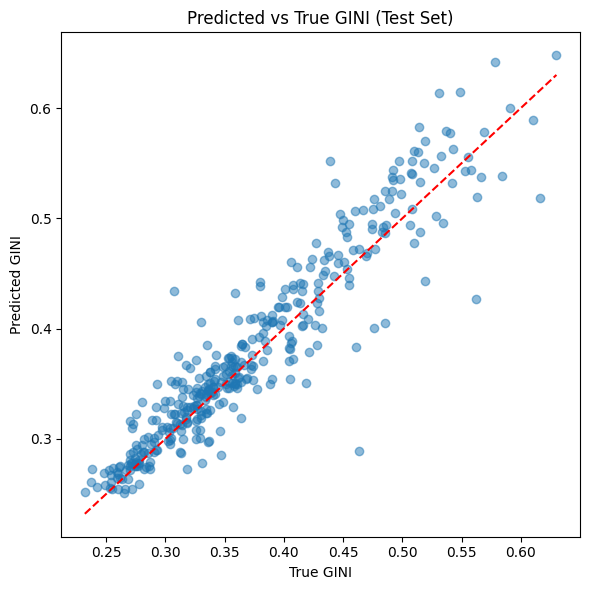

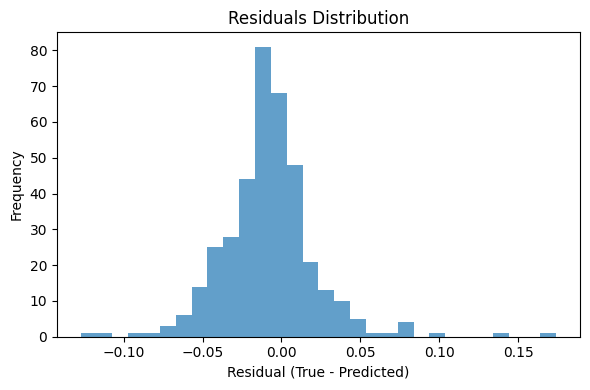

In [14]:
true, pred = evaluate_model(gan_model, test_loader, device)

In [15]:
#--- ATTENTION per network

attn = torch.softmax(gan_model.attn_weights, dim=0)
print(attn)

tensor([0.2213, 0.1810, 0.1794, 0.2087, 0.2097], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


#### Predict for countries with missing values

In [16]:
def predict_missing_gini_2022(model, data_years, df_gini, device, year=2022, printing=True):
    """
    Predict GINI values for countries that have missing/NaN GINI data in 2022.
    """
    model.eval()
    
    if year not in data_years:
        print(f"Year {year} not available in data")
        return None
    
    year_data = data_years[year]
    
    # Get ALL countries for 2022 from df_gini (including those with NaN values)
    df_gini_2022 = df_gini[df_gini['year'] == year].copy()
    df_gini_2022['country_id'] = df_gini_2022['country'].map(lambda x: convert_country_code(x, 'UNnumeric'))
    df_gini_2022 = df_gini_2022.dropna(subset=['country_id'])
    df_gini_2022['country_id'] = df_gini_2022['country_id'].astype(int)
    
    # Countries that have valid (non-NaN) GINI data in 2022
    countries_with_valid_gini = set(df_gini_2022[df_gini_2022['gini'].notna()]['country_id'])
    
    # Countries that have missing/NaN GINI data in 2022
    countries_with_missing_gini = set(df_gini_2022[df_gini_2022['gini'].isna()]['country_id'])
    
    with torch.no_grad():
        # Move data to device
        data_dict = {k: (v.to(device) if hasattr(v, 'to') else v) for k, v in year_data.items() if k != 'GINI'}
        
        # Get model predictions for all countries
        output = model(data_dict)
        
        # Get country IDs from any modality (they should be consistent)
        country_ids = data_dict['geography'].country_id.cpu().numpy()
        pred_gini = output.cpu().numpy().flatten()
        
        # Find countries that are in our network data AND have missing GINI values
        countries_to_predict = []
        predictions_for_missing = []
        
        for i, country_id in enumerate(country_ids):
            # Check if this country has missing GINI data in 2022
            if country_id in countries_with_missing_gini:
                countries_to_predict.append(country_id)
                predictions_for_missing.append(pred_gini[i])
        
        # Also check for countries that are in network data but not in GINI data at all for 2022
        all_gini_countries_2022 = set(df_gini_2022['country_id'])
        for i, country_id in enumerate(country_ids):
            if country_id not in all_gini_countries_2022:
                countries_to_predict.append(country_id)
                predictions_for_missing.append(pred_gini[i])
        
        if printing and len(countries_to_predict) > 0:
            print(f"GINI Predictions for Countries with Missing 2022 Data:")
            print(f"{'Country':<20} {'ISO3':<8} {'Predicted GINI':<15}")
            print("-" * 50)
            
            # Convert country IDs to names and ISO3 codes
            country_names = coco.convert(countries_to_predict, src="UNnumeric", to="name_short")
            iso3_codes = coco.convert(countries_to_predict, src="UNnumeric", to="ISO3")
            
            # Create results list for sorting
            results = []
            for country_id, name, iso3, pred in zip(countries_to_predict, country_names, iso3_codes, predictions_for_missing):
                results.append({
                    'country_id': country_id,
                    'name': name,
                    'iso3': iso3,
                    'predicted_gini': pred * 100  # Convert back to 0-100 scale
                })
            
            # Sort by predicted GINI (highest to lowest)
            results.sort(key=lambda x: x['predicted_gini'], reverse=True)
            
            for result in results:
                print(f"{result['name']:<20} {result['iso3']:<8} {result['predicted_gini']:<15.2f}")
            
            print(f"\nTotal countries with missing GINI data in {year}: {len(countries_to_predict)}")
            print(f"Countries with valid GINI data in {year}: {len(countries_with_valid_gini)}")
            print(f"Average predicted GINI: {np.mean([r['predicted_gini'] for r in results]):.2f}")
            print(f"Median predicted GINI: {np.median([r['predicted_gini'] for r in results]):.2f}")
            print(f"Range: {min([r['predicted_gini'] for r in results]):.2f} - {max([r['predicted_gini'] for r in results]):.2f}")
            
            return results
        
        elif printing:
            print(f"All countries have GINI data available for {year}")
            return []
        
        else:
            # Return results without printing
            country_names = coco.convert(countries_to_predict, src="UNnumeric", to="name_short")
            iso3_codes = coco.convert(countries_to_predict, src="UNnumeric", to="ISO3")
            
            results = []
            for country_id, name, iso3, pred in zip(countries_to_predict, country_names, iso3_codes, predictions_for_missing):
                results.append({
                    'country_id': country_id,
                    'name': name,
                    'iso3': iso3,
                    'predicted_gini': pred * 100
                })
            
            return results

# Use your trained model to predict missing GINI values for 2022
print("="*60)
print("PREDICTING GINI FOR COUNTRIES WITH MISSING 2022 DATA")
print("="*60)

missing_gini_predictions = predict_missing_gini_2022(
    gan_model, data_years, df_gini, device, year=2022, printing=True
)

PREDICTING GINI FOR COUNTRIES WITH MISSING 2022 DATA
GINI Predictions for Countries with Missing 2022 Data:
Country              ISO3     Predicted GINI 
--------------------------------------------------
Monaco               MCO      200.12         
Liechtenstein        LIE      199.12         
South Africa         ZAF      64.37          
Namibia              NAM      60.20          
Eswatini             SWZ      57.89          
Botswana             BWA      56.80          
Zimbabwe             ZWE      53.09          
Panama               PAN      52.03          
Mozambique           MOZ      51.60          
Guatemala            GTM      51.24          
Bahamas              BHS      49.64          
Rwanda               RWA      49.27          
Lesotho              LSO      49.26          
Nicaragua            NIC      49.25          
Honduras             HND      48.88          
Madagascar           MDG      48.27          
Angola               AGO      47.68          
Venezuela    

In [17]:
missing_gini_predictions

[{'country_id': np.int64(492),
  'name': 'Monaco',
  'iso3': 'MCO',
  'predicted_gini': np.float32(200.1221)},
 {'country_id': np.int64(438),
  'name': 'Liechtenstein',
  'iso3': 'LIE',
  'predicted_gini': np.float32(199.11829)},
 {'country_id': np.int64(710),
  'name': 'South Africa',
  'iso3': 'ZAF',
  'predicted_gini': np.float32(64.3676)},
 {'country_id': np.int64(516),
  'name': 'Namibia',
  'iso3': 'NAM',
  'predicted_gini': np.float32(60.199974)},
 {'country_id': np.int64(748),
  'name': 'Eswatini',
  'iso3': 'SWZ',
  'predicted_gini': np.float32(57.887787)},
 {'country_id': np.int64(72),
  'name': 'Botswana',
  'iso3': 'BWA',
  'predicted_gini': np.float32(56.79691)},
 {'country_id': np.int64(716),
  'name': 'Zimbabwe',
  'iso3': 'ZWE',
  'predicted_gini': np.float32(53.09299)},
 {'country_id': np.int64(591),
  'name': 'Panama',
  'iso3': 'PAN',
  'predicted_gini': np.float32(52.025723)},
 {'country_id': np.int64(508),
  'name': 'Mozambique',
  'iso3': 'MOZ',
  'predicted_gini'

In [ ]:
# def evaluate_model_with_countries(model, test_loader, device, printing=True):
#     model.eval()
#     all_true = []
#     all_pred = []
#     all_country_ids = []
    
#     with torch.no_grad():
#         for data_dict in test_loader:
#             # Move data to device if not already
#             data_dict = {k: (v.to(device) if hasattr(v, 'to') else v) for k, v in data_dict.items()}
#             output = model(data_dict)
#             mask = torch.tensor(data_dict['GINI'].exists, dtype=torch.bool, device=output.device).flatten()
            
#             true = data_dict['GINI'].y[mask].cpu().numpy()
#             pred = output[mask].cpu().numpy()
#             country_ids = data_dict['GINI'].country_id[mask].cpu().numpy()
            
#             all_true.append(true)
#             all_pred.append(pred)
#             all_country_ids.append(country_ids)
    
#     # Concatenate results from all batches
#     all_true = np.concatenate(all_true, axis=0)
#     all_pred = np.concatenate(all_pred, axis=0)
#     all_country_ids = np.concatenate(all_country_ids, axis=0)
    
#     # Find the outlier (largest absolute residual)
#     residuals = np.abs(all_true - all_pred)
#     outlier_idx = np.argmax(residuals)
#     outlier_country_id = all_country_ids[outlier_idx]
#     outlier_true = all_true[outlier_idx]
#     outlier_pred = all_pred[outlier_idx]
    
#     # Convert country ID back to country name - fix: pass as list
#     outlier_country_name = coco.convert([outlier_country_id], to='name_short')[0]
    
#     if printing:
#         print(f"Outlier country: {outlier_country_name} (ID: {outlier_country_id})")
#         print(f"True GINI: {outlier_true.item():.4f}, Predicted GINI: {outlier_pred.item():.4f}")
#         print(f"Absolute error: {residuals[outlier_idx].item():.4f}")
    
#     return all_true, all_pred, all_country_ids, outlier_country_name

# # Run the modified evaluation
# true, pred, country_ids, outlier_country = evaluate_model_with_countries(gan_model, test_loader, device)

### Evaluating on test countries without a gini in 2022

In [25]:
# only gini til 2021
df_gini2021 = df_gini[df_gini['year'].between(2000, 2022)].reset_index(drop=True)

In [26]:
# Define your test countries
test_countries = ["FRA", "POL", "SWE", "IND", "IRN", "IDN", 
                  "ZMB", "TCD", "USA", "BRA", "MEX", "BTN", "MLT", "SUR"]
test_countries_numeric = coco.convert(test_countries, to="UNnumeric")

# Create a version of df_gini with specific countries' GINI data removed
def create_gini_data_excluding_test_countries(df_gini, test_countries_numeric, year_col='year', country_col='country', gini_col='gini'):
    """
    Create GINI data where test countries have their GINI values set to NaN/missing,
    but other countries keep their real GINI values for all years including 2022.
    """
    uno_iso3_codes, _ = get_un_countries()
    df_gini_modified = df_gini.copy()
    
    # Convert country codes to numeric for comparison
    df_gini_modified['country_id'] = df_gini_modified[country_col].map(lambda x: convert_country_code(x, 'UNnumeric'))
    
    # Set GINI values to NaN for test countries (this simulates missing data)
    test_mask = df_gini_modified['country_id'].isin(test_countries_numeric)
    df_gini_modified.loc[test_mask, gini_col] = np.nan
    
    # Continue with normal processing
    df_gini_modified = df_gini_modified[df_gini_modified[country_col].isin(uno_iso3_codes)].copy()
    df_gini_modified = df_gini_modified.sort_values(by=['country_id']).reset_index(drop=True)
    df_gini_modified = df_gini_modified.dropna(subset=['country_id'])
    df_gini_modified[gini_col] = df_gini_modified[gini_col] / 100  # Normalize to [0,1]
    df_gini_modified['exists'] = 1
    df_gini_modified.loc[df_gini_modified[gini_col].isna(), 'exists'] = 0
    df_gini_modified.loc[df_gini_modified[gini_col].isna(), gini_col] = 0

    gini_data_dict = {}
    years = df_gini_modified[year_col].unique()
    for year in years:
        df_year = df_gini_modified[df_gini_modified[year_col] == year].copy()
        df_year['country_id'] = df_year['country_id'].astype(int)
        gini_tensor = torch.tensor(df_year[gini_col].values, dtype=torch.float32)
        country_id_tensor = torch.tensor(df_year['country_id'].values, dtype=torch.long)
        data = Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, exists=df_year['exists'].values)
        gini_data_dict[year] = data
    return gini_data_dict

# Create modified GINI data (excluding test countries)
gini_data_modified = create_gini_data_excluding_test_countries(df_gini, test_countries_numeric)

# Rebuild data_years with modified GINI data
data_years_modified = {}
common_years = sorted(set(geo_data.keys()) & set(pol_data.keys()) & set(cul_data.keys()) & set(lang_data.keys()) & set(eco_data.keys()))

for year in common_years:
    data_years_modified[year] = {
        'geography': geo_data[year],
        'political': pol_data[year], 
        'culture': cul_data[year],
        'language': lang_data[year],
        'economy': eco_data[year],
        'GINI': gini_data_modified.get(year)  
    }

# Create train/val/test splits using all years (including 2022)
all_years_modified = sorted([y for y in data_years_modified.keys() if data_years_modified[y]['GINI'] is not None])
train_years_modified, test_years_modified = train_test_split(all_years_modified, test_size=0.2, random_state=42)
train_years_modified, val_years_modified = train_test_split(train_years_modified, test_size=0.25, random_state=42)

train_set_modified = [data_years_modified[y] for y in train_years_modified]
val_set_modified = [data_years_modified[y] for y in val_years_modified]
test_set_modified = [data_years_modified[y] for y in test_years_modified]

print(f"Training on {len(train_set_modified)} years, validating on {len(val_set_modified)} years, testing on {len(test_set_modified)} years")
print(f"Years include data up to: {max(all_years_modified)}")

Training on 13 years, validating on 5 years, testing on 5 years
Years include data up to: 2022


Training model with test countries' GINI data excluded...
Starting training...
Epoch: 1, Training Loss: 0.2843, Validation Loss: 0.1744
Validation loss decreased (0.174407 --> 0.174407).  Saving model ...
Epoch: 2, Training Loss: 0.1837, Validation Loss: 0.0764
Validation loss decreased (0.174407 --> 0.076420).  Saving model ...
Epoch: 3, Training Loss: 0.2089, Validation Loss: 0.0831
Epoch: 4, Training Loss: 0.1514, Validation Loss: 0.0985
Epoch: 5, Training Loss: 0.1188, Validation Loss: 0.0831
Epoch: 6, Training Loss: 0.1305, Validation Loss: 0.1183
Epoch: 7, Training Loss: 0.1224, Validation Loss: 0.0704
Validation loss decreased (0.076420 --> 0.070386).  Saving model ...
Epoch: 8, Training Loss: 0.0896, Validation Loss: 0.0581
Validation loss decreased (0.070386 --> 0.058087).  Saving model ...
Epoch: 9, Training Loss: 0.0662, Validation Loss: 0.0608
Epoch: 10, Training Loss: 0.0882, Validation Loss: 0.0522
Validation loss decreased (0.058087 --> 0.052245).  Saving model ...
Epoch

Text(0.5, 1.0, 'Training Progress')

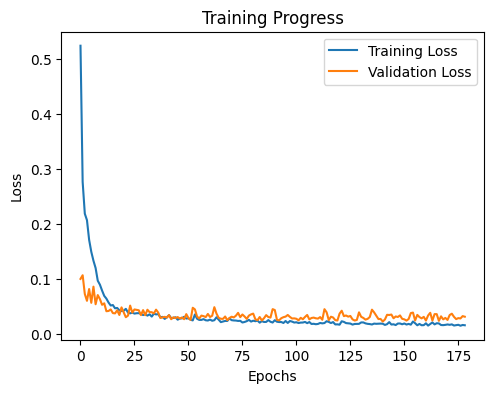

In [27]:
# retrain
train_set_modified = [move_data_dict_to_device(d, device) for d in train_set_modified]
val_set_modified = [move_data_dict_to_device(d, device) for d in val_set_modified]
test_set_modified = [move_data_dict_to_device(d, device) for d in test_set_modified]

train_loader_modified = DataLoader(train_set_modified, batch_size=1, shuffle=True)
val_loader_modified = DataLoader(val_set_modified, batch_size=1, shuffle=False)

# new model
gan_model_modified = MultiModalGNNModel(
    input_dims=network_dimesions, hidden_size=148, n_dim_mlp_layers=0, 
    combination_method="attention", mlp_variant="deep", n_gat_layers=1
)
gan_model_modified = gan_model_modified.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(gan_model_modified.parameters(), lr=0.0006502342591153078, weight_decay=0.0000003414375524585915)
early_stopper = EarlyStopping(patience=50, min_delta=0.0001, path='model_checkpoints/gan_checkpoint_modified.pt')

print("Training model with test countries' GINI data excluded...")
train_losses_modified, val_losses_modified = train_gnn(
    1000, gan_model_modified, optimizer, criterion, 
    train_loader_modified, val_loader_modified, early_stopper
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gan, label='Training Loss')
plt.plot(val_losses_gan, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')

GNN MODEL PREDICTIONS FOR TEST COUNTRIES (2022)
Predictions vs True Values for Test Countries (2022):
Country  True GINI    Predicted    Difference  
--------------------------------------------------
BTN      0.2850       0.4343       0.1493      
BRA      0.5200       0.4599       -0.0601     
TCD      0.3740       0.4070       0.0330      
FRA      0.3120       0.3410       0.0290      
IND      0.2550       0.4121       0.1571      
IDN      0.3550       0.4722       0.1172      
IRN      0.3480       0.3826       0.0346      
MLT      0.3460       0.3858       0.0398      
MEX      0.4350       0.4347       -0.0003     
POL      0.2890       0.3430       0.0540      
SUR      0.3920       0.3559       -0.0361     
SWE      0.3160       0.2849       -0.0311     
USA      0.4170       0.3832       -0.0338     
ZMB      0.5150       0.4056       -0.1094     

GNN Model Performance on Test Countries (2022):
MSE: 0.0062
RMSE: 0.0790
MAE: 0.0632
MAPE: 18.95%
R²: -0.0274


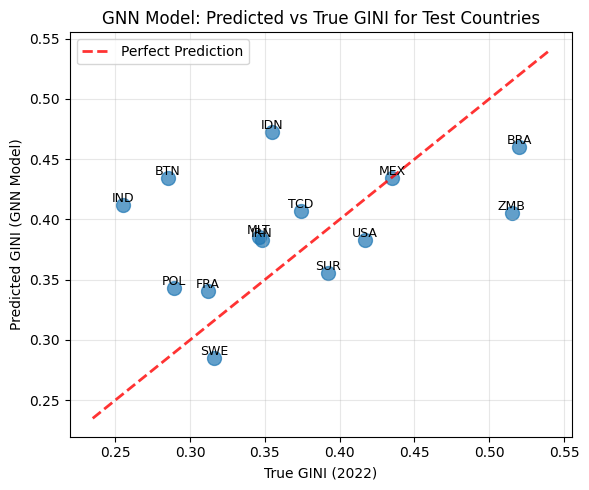

In [28]:
def evaluate_specific_countries_with_plot(model, data_years, test_countries_numeric, device, year=2022, printing=True):
    """
    Evaluate the model on specific test countries for a given year with visualization.
    """
    model.eval()
    
    if year not in data_years:
        print(f"Year {year} not available in data")
        return None, None
    
    year_data = data_years[year]
    
    with torch.no_grad():
        data_dict = {k: (v.to(device) if hasattr(v, 'to') else v) for k, v in year_data.items() if k != 'GINI'}
        output = model(data_dict)
        
        # get country ids
        country_ids = data_dict['geography'].country_id.cpu().numpy()
        pred_gini = output.cpu().numpy().flatten()
        
        # filter test countries
        test_country_mask = np.isin(country_ids, test_countries_numeric)
        
        if not np.any(test_country_mask):
            print(f"No test countries found in {year} data")
            return None, None
        
        test_country_ids = country_ids[test_country_mask]
        test_pred = pred_gini[test_country_mask]
        
        # Get true GINI values from df_gini
        df_gini_year = df_gini[df_gini['year'] == year].copy()
        df_gini_year['country_id'] = df_gini_year['country'].map(lambda x: convert_country_code(x, 'UNnumeric'))
        df_gini_year = df_gini_year.dropna(subset=['country_id'])
        df_gini_year['country_id'] = df_gini_year['country_id'].astype(int)
        
        # Create mapping from country_id to true GINI
        country_to_gini = dict(zip(df_gini_year['country_id'], df_gini_year['gini'] / 100))  # Normalize to [0,1]
        
        # Get true values for test countries
        true_values = []
        available_country_ids = []
        available_predictions = []
        
        for i, country_id in enumerate(test_country_ids):
            if country_id in country_to_gini:
                true_values.append(country_to_gini[country_id])
                available_country_ids.append(country_id)
                available_predictions.append(test_pred[i])
        
        if printing and len(available_country_ids) > 0:
            print(f"Predictions vs True Values for Test Countries ({year}):")
            print(f"{'Country':<8} {'True GINI':<12} {'Predicted':<12} {'Difference':<12}")
            print("-" * 50)
            
            iso3_labels = coco.convert(available_country_ids, src="UNnumeric", to="ISO3")
            for country_id, true_val, pred_val, iso in zip(available_country_ids, true_values, available_predictions, iso3_labels):
                diff = pred_val - true_val
                print(f"{iso:<8} {true_val:<12.4f} {pred_val:<12.4f} {diff:<12.4f}")
            
            # Calculate metrics
            from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
            
            true_array = np.array(true_values)
            pred_array = np.array(available_predictions)
            
            mse = mean_squared_error(true_array, pred_array)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(true_array, pred_array)
            r2 = r2_score(true_array, pred_array)
            mape = np.mean(np.abs((true_array - pred_array) / true_array)) * 100
            
            print(f"\nGNN Model Performance on Test Countries ({year}):")
            print(f"MSE: {mse:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"R²: {r2:.4f}")
            

            # plot predicted vs true
            plt.figure(figsize=(6, 5))
            plt.scatter(true_array, pred_array, color="C0", s=100, alpha=0.7)
            for true_val, pred_val, iso in zip(true_array, pred_array, iso3_labels):
                plt.text(true_val, pred_val, iso, fontsize=9, ha='center', va='bottom')
            
            min_val = min(true_array.min(), pred_array.min()) - 0.02
            max_val = max(true_array.max(), pred_array.max()) + 0.02
            plt.plot([min_val, max_val], [min_val, max_val], '--r', alpha=0.8, linewidth=2, label='Perfect Prediction')
            
            plt.xlabel("True GINI (2022)")
            plt.ylabel("Predicted GINI (GNN Model)")
            plt.title(f"GNN Model: Predicted vs True GINI for Test Countries")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        elif printing:
            print(f"No true GINI values available for test countries in {year}")
                
        return test_country_ids, test_pred

# Define test countries and run evaluation
test_countries = ["FRA", "POL", "SWE", "IND", "IRN", "IDN", 
                  "ZMB", "TCD", "USA", "BRA", "MEX", "BTN", "MLT", "SUR"]
test_countries_numeric = coco.convert(test_countries, to="UNnumeric")

print("GNN MODEL PREDICTIONS FOR TEST COUNTRIES (2022)")

# Use the modified model that was trained WITHOUT test countries' GINI data
test_country_ids, test_predictions = evaluate_specific_countries_with_plot(
    gan_model_modified, data_years, test_countries_numeric, device, year=2022, printing=True
)

## Hyperparameter Tuning with Optuna

In [23]:
import optuna

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def move_data_dict_to_device(data_dict, device):
    moved = {}
    for k, v in data_dict.items():
        if hasattr(v, 'to'):
            moved[k] = v.to(device)
        else:
            moved[k] = v
    return moved

train_set = [move_data_dict_to_device(d, device) for d in train_set]
val_set = [move_data_dict_to_device(d, device) for d in val_set]
test_set = [move_data_dict_to_device(d, device) for d in test_set]


def objective(trial):
    
    hidden_size = trial.suggest_int("hidden_size", 20, 300, step=16)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    
    n_gat_layers = trial.suggest_int("n_gat_layers", 1, 3)
    n_dim_mlp_layers = trial.suggest_int("n_dim_mlp_layers", 0, 3)
    combination_method = trial.suggest_categorical("combination_method", ['concat', 'attention'])
    batch_size = trial.suggest_int("batch_size", 2, 8, step=1)
    
    mlp_variant = trial.suggest_categorical("mlp_variant", ['default', 'deep', 'shallow'])


    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    gan_model = MultiModalGNNModel(
        input_dims=network_dimesions, hidden_size=hidden_size,
        n_gat_layers=n_gat_layers, n_dim_mlp_layers=n_dim_mlp_layers,
        combination_method=combination_method,
        mlp_variant=mlp_variant)
    
    gan_model = gan_model.to(device)
    
    # criterion for regression task
    criterion = MeanAbsolutePercentageError().to(device)
    
    # Fix 7: Better optimizer settings for this problem
    optimizer = optim.Adam(gan_model.parameters(), lr=lr, weight_decay=weight_decay)  # Lower LR and weight decay
    
    # Initialize early stopping
    early_stopper = EarlyStopping(patience=30, min_delta=0.00001, path='model_checkpoints/gan_checkpoint_optuna.pt', printing=False)
    
    # Train the model
    epochs = 1000
    train_losses_gan, val_losses_gan = train_gnn(epochs, gan_model, optimizer, criterion, train_loader, val_loader, early_stopper, printing=False)
    
    # Evaluate the model on the validation set
    true, pred = evaluate_model(gan_model, val_loader, device, printing =False)
    mape = np.mean(np.abs((true - pred) / np.abs(true))) * 100
    
    return mape

study = optuna.create_study(
    study_name = "Multimodal_base",
    storage="sqlite:///optuna_study_optimized.db",
    direction="minimize",
    load_if_exists=True)
# study.optimize(objective, n_trials=50) # comment out to run new trail

print("Best trial:")
print(study.best_trial.params)

[I 2025-08-27 07:46:10,339] Using an existing study with name 'Multimodal_base' instead of creating a new one.


Best trial:
{'hidden_size': 148, 'weight_decay': 3.414375524585915e-07, 'lr': 0.0006502342591153078, 'n_gat_layers': 1, 'n_dim_mlp_layers': 0, 'combination_method': 'attention', 'batch_size': 3, 'mlp_variant': 'deep'}


best performance with deep MLP and only 1 GAT layer..... maybe network is not soooo important after all....